# Analysis of the PILS experiments

This notebook is intended to provide a mostly graphical and comprehensive summary of the experiments conducted to study the idea of partly integrated latent space learning for the paired ATACseq and RNAseq data published by Cao et al. (2018).

----

## 0. Environmental setup

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
from IPython.display import Image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.utils.basic.evaluation import evaluate_partly_integrated_latent_space_paired_data_experiments
import seaborn as sn

---

## 1. Data summary

The data subject to the analyses describes a population of A549 cells to which a DEX treatment was applied. Using the scCAR method the cells were sequenced to obtain the gene expression and DNA activity profiles. In total 1874 cells could be sequenced such that the two different data modalities were recorded at a quality that passed the set standards.

For the ATACseq data 815 transcription factor motifs were derived as described by Cao et al. (2018). To reduce the dimensionality of the gene expression data the subset of genes were selected that showed to be differently expressed with a FWER of less than 5%. The resulting paired data sets hence consist of 1874 cells with 815 features for the ATACseq domain and 2613 features for the RNAseq domain. Both data sets were preprocessed log-transformed:
$$\begin{equation}
    z = log(x+1)
\end{equation}$$
with $x$ being the a raw feature (e.g. some read count for a certain gene) and after that normalized as
$$\begin{equation}
    \hat{z} = \frac{z-z_{med}}{z_{0.75}-z_{0.25}},
\end{equation}$$
where $z_{med}$ is the median of the feature log transformed feature $z$ and $z_{\alpha}$ denotes the $\alpha$-quantile of the empirical distribution of it.

---

## 2. Normal setting

At first the models used in the experiment were designed considering the classical U-shape bias-variance tradeoff setting. Further analyses will extend the analyses to the overparameterized setting to exploit the double-descent characteristic of the validation loss that has been shown to better describe what is empirically seen in many applications in deep learning (see Belkin et al. (2019)). 

### 2a. Basic experimental setup

The following list summarizes the basic setup of the conducted experiments.

| Element | Setting |
| --- | --- |
| Evaluation | 5-fold stratified CV (80-20 train-val split for monitoring) |
|Number of epochs | 1000 |
|Reconstruction loss (weight) | MAE (0.1) |
|Discriminator loss (weight) | Cross-entropy (1.0) |
|Latent structure loss (weight) | Cross-entropy (0.001) |
|Shared latent space ratio | 0.4, 0.8, 1.0 |
|Supervision rate|0, 0.5, 1.0|
|Total latent space size| 50 |

### 2b. Setup of the models

In the following the setups of the models that were used for the experiments are summarized.

#### 2b. i) RNA autoencoder

|Element|Setting|
|---|---|
|Input size| 2613|
|Network type| FCN|
|Hidden layers| 1024, 512, 256, 128, (50), ...|
|Optimizer | RMSprop|
|learning rate| 1e-4|
|regularization| 5e-4 ($l_2$)|

#### 2b. ii) ATAC autoencoder

|Element|Setting|
|---|---|
|Input size| 815|
|Network type| FCN|
|Hidden layers| 512, 256, 128, 64, (50), ...|
|Optimizer | RMSprop|
|learning rate| 1e-4|
|regularization| 5e-4 ($l_2$)|

#### 2b. iii) Latent discriminator

|Element|Setting|
|---|---|
|Input size| shared latent space size|
|Network type| FCN|
|Hidden layers| 128, 128, 128|
|Output size|2|
|Optimizer | RMSprop|
|learning rate| 1e-4|
|regularization| - |

#### 2b iv) Latent classifier

|Element|Setting|
|---|---|
|Input size| shared latent space size|
|Network type| Linear |
|Hidden layers| -|
|Output size|3|
|Optimizer | RMSprop|
|learning rate| 1e-4|
|regularization| - |

---

### 2c. Experimental results

In the following we will summarize the results of the experiments whose setup was described previously.

In [3]:
experiment_dir = '/home/paysan_d/PycharmProjects/domain_translation/data/a549_dex/final_experiments/pils_correct'
reconstruction_results, latent_distance_results, knn_results = \
evaluate_partly_integrated_latent_space_paired_data_experiments(experiment_dir)

#### 2c. i) Reconstruction results

We will first compare the distribution of the reconstruction loss performance for the individual domains to study the effect of the supervision and the ratio of the shared latent space on the reconstruction performance for the individual domains.

As an explanation in the following the term 'shared ratio' will be used to describe the percentage of the dimension being shared for the two data domains, i.e. the number of the dimensions of the latent space that is pushed to be shared by the adversarial training is 
$$dim(\mathcal{Z}) = \textrm{shared ratio} * 50.$$

In [4]:
rna_recon_data = reconstruction_results.loc[reconstruction_results['domain'] == 'rna']
atac_recon_data = reconstruction_results.loc[reconstruction_results['domain'] == 'atac']

##### RNA autoencoder

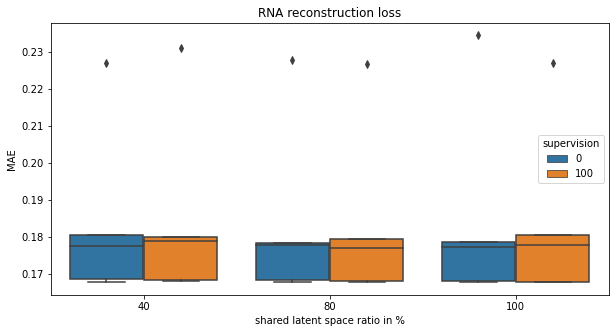

In [5]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
sn.boxplot(x='shared_ratio', y='reconstruction_loss', hue='supervision', data=rna_recon_data, ax=ax)
ax.set_title('RNA reconstruction loss')
ax.set_xlabel('shared latent space ratio in %')
ax.set_ylabel('MAE')
plt.show()

##### ATAC autoencoder

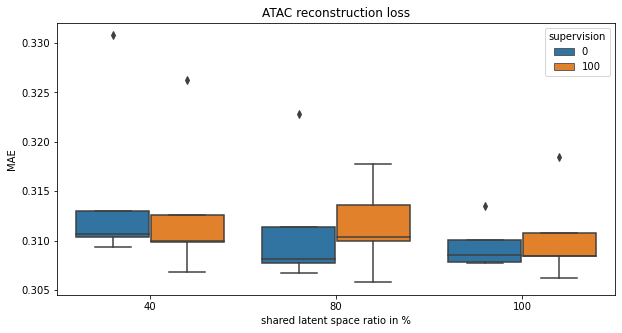

In [6]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
sn.boxplot(x='shared_ratio', y='reconstruction_loss', hue='supervision', data=atac_recon_data, ax=ax)
ax.set_title('ATAC reconstruction loss')
ax.set_xlabel('shared latent space ratio in %')
ax.set_ylabel('MAE')
plt.show()

##### Summary

When analyzing the obtained results for the reconstruction loss the fact that the reconstruction loss seems to be unaffected by change of the ratio of how many dimensions of the latent space are shared is unexpected. Intuitively we would expect the reconstruction error to be reducing if we allow more freedom to the models to fit a latent space of the same dimensionality. This is because we loosen the constraints on the latent space with respect to its integration. 

However, neither for the RNAseq nor for the ATACseq domain the reconstruction losses differ significantly for the different ratios of shared latent space dimensions. A possible explanation could be that the lower dimensional manifold in which we aim to embed the two data modalities actually share the vast majority of the dimensions. Thus even if we do not actively enforce the complete integration of the latent spaces the models converge to a solution where the two learned latent spaces are (almost) fully integrated.

An analysis of the correlation structure of the learned latent space features backs this impression as we see the domain-specific features of the latent spaces to be highly correlated with features from the shared latent space.

In the following we illustrate the learned correlation structure on the training set after 950 epochs of the 4th fold for 40%, 80% and 100% shared latent space dimensions with 0% supervision for the training set, i.e. not using any information about which data samples refer to the same cell during training.

###### Shared latent space ratio 40% (0% supervision)

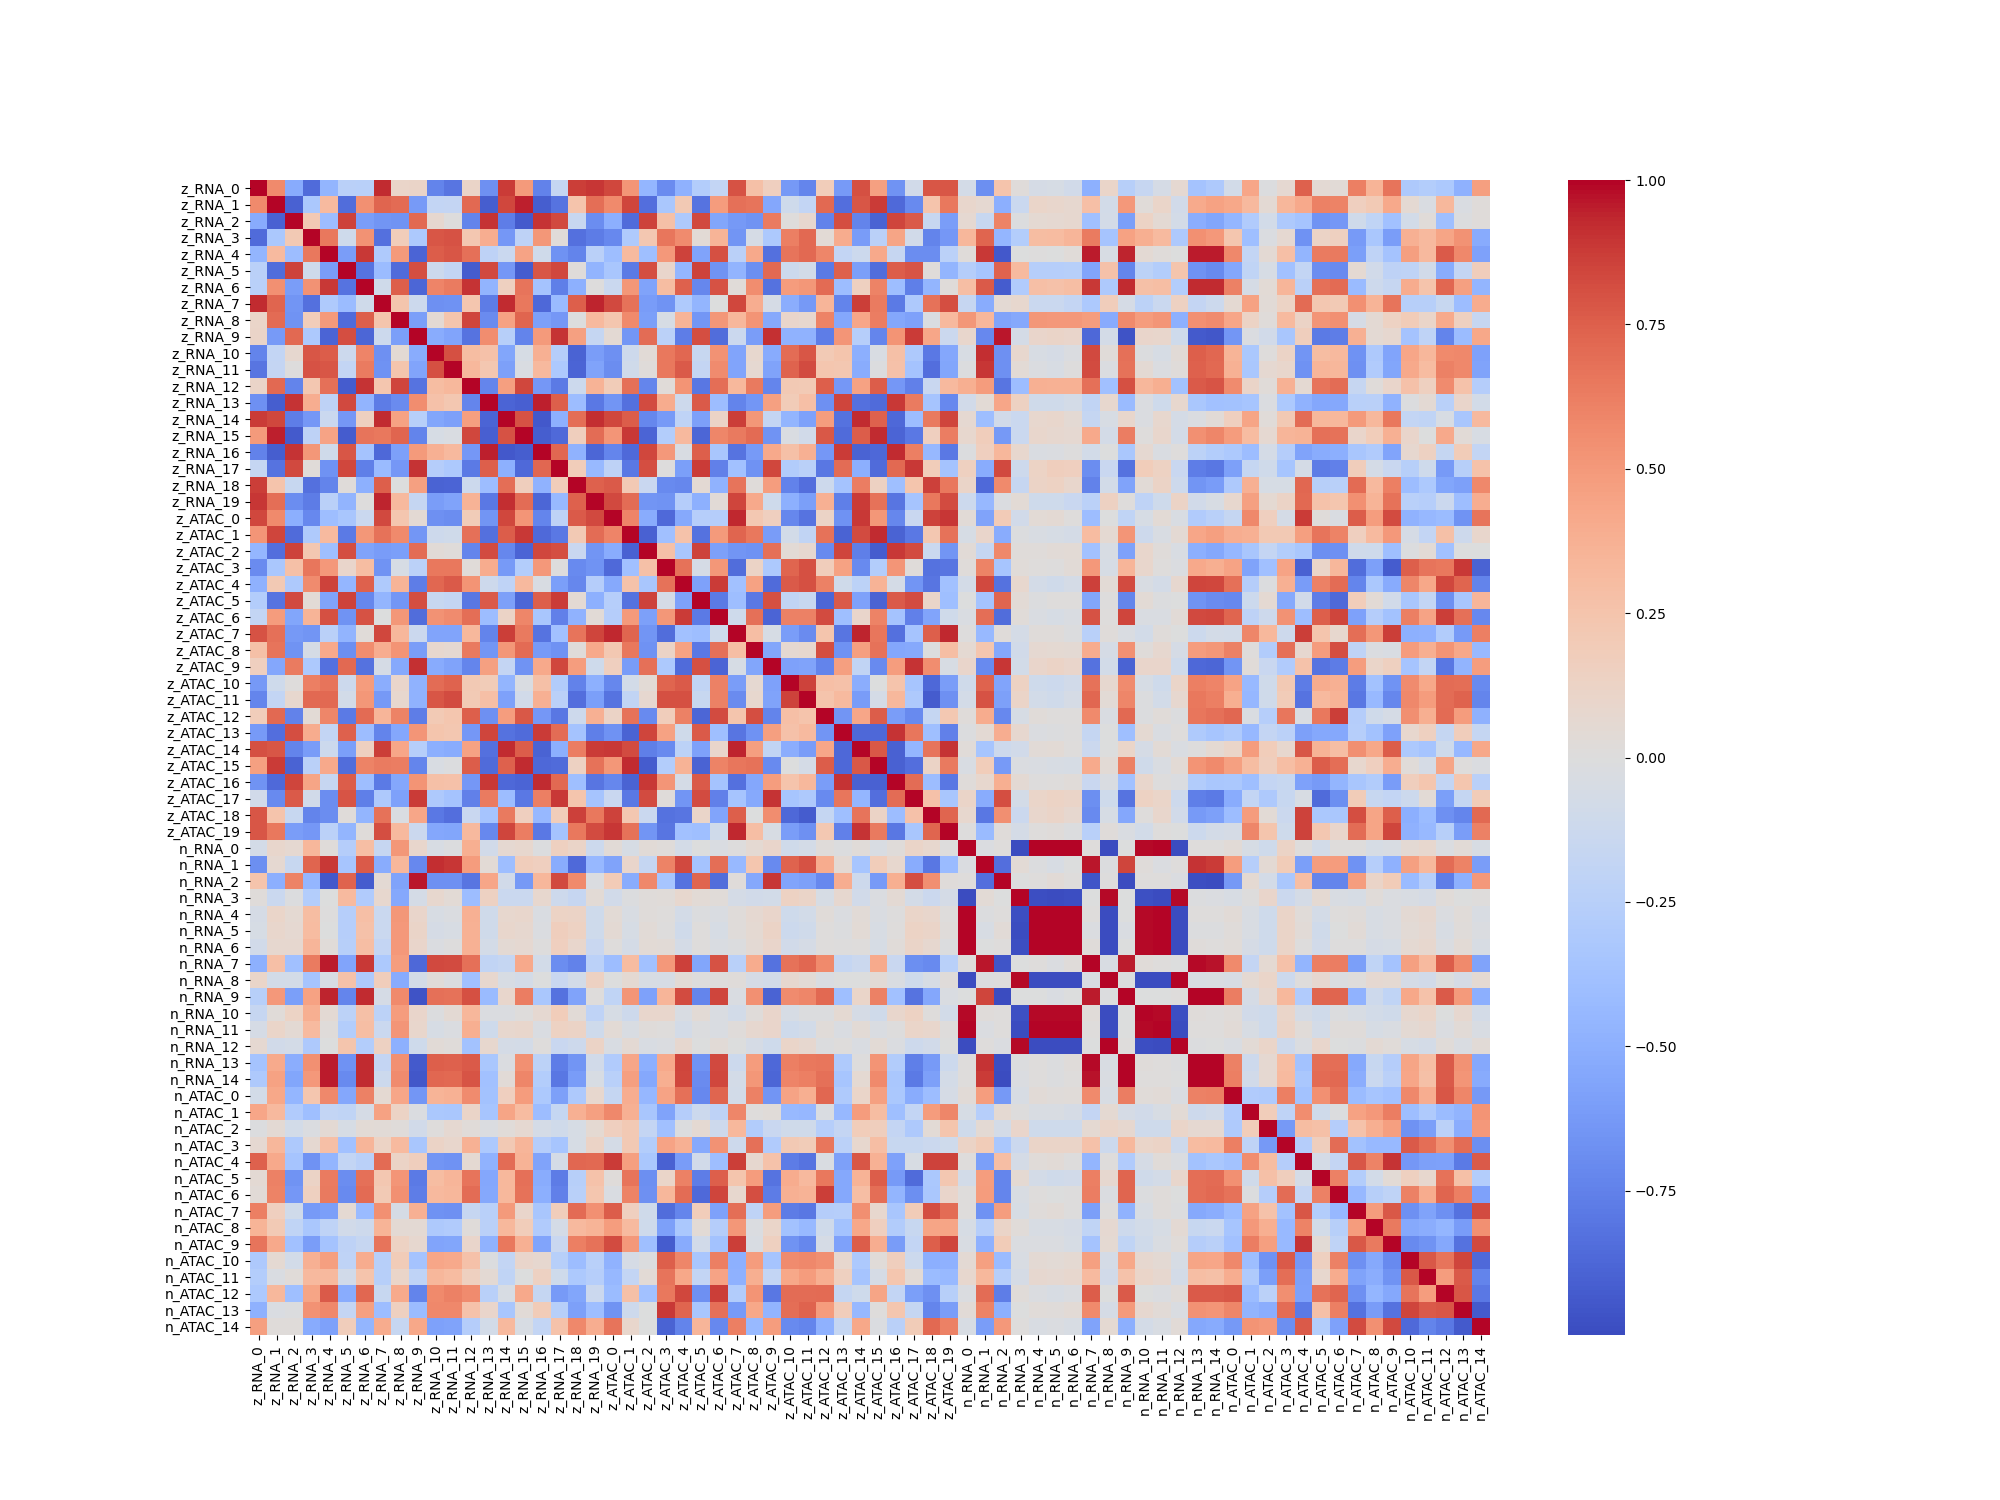

In [7]:
Image(filename='/home/paysan_d/PycharmProjects/domain_translation/data/a549_dex/final_experiments/pils_correct/40_0/fold_4/epoch_950/latent_space_correlation_structure_train.png', width = 800, height = 600)

###### Shared latent space ratio 80% (100% supervision)

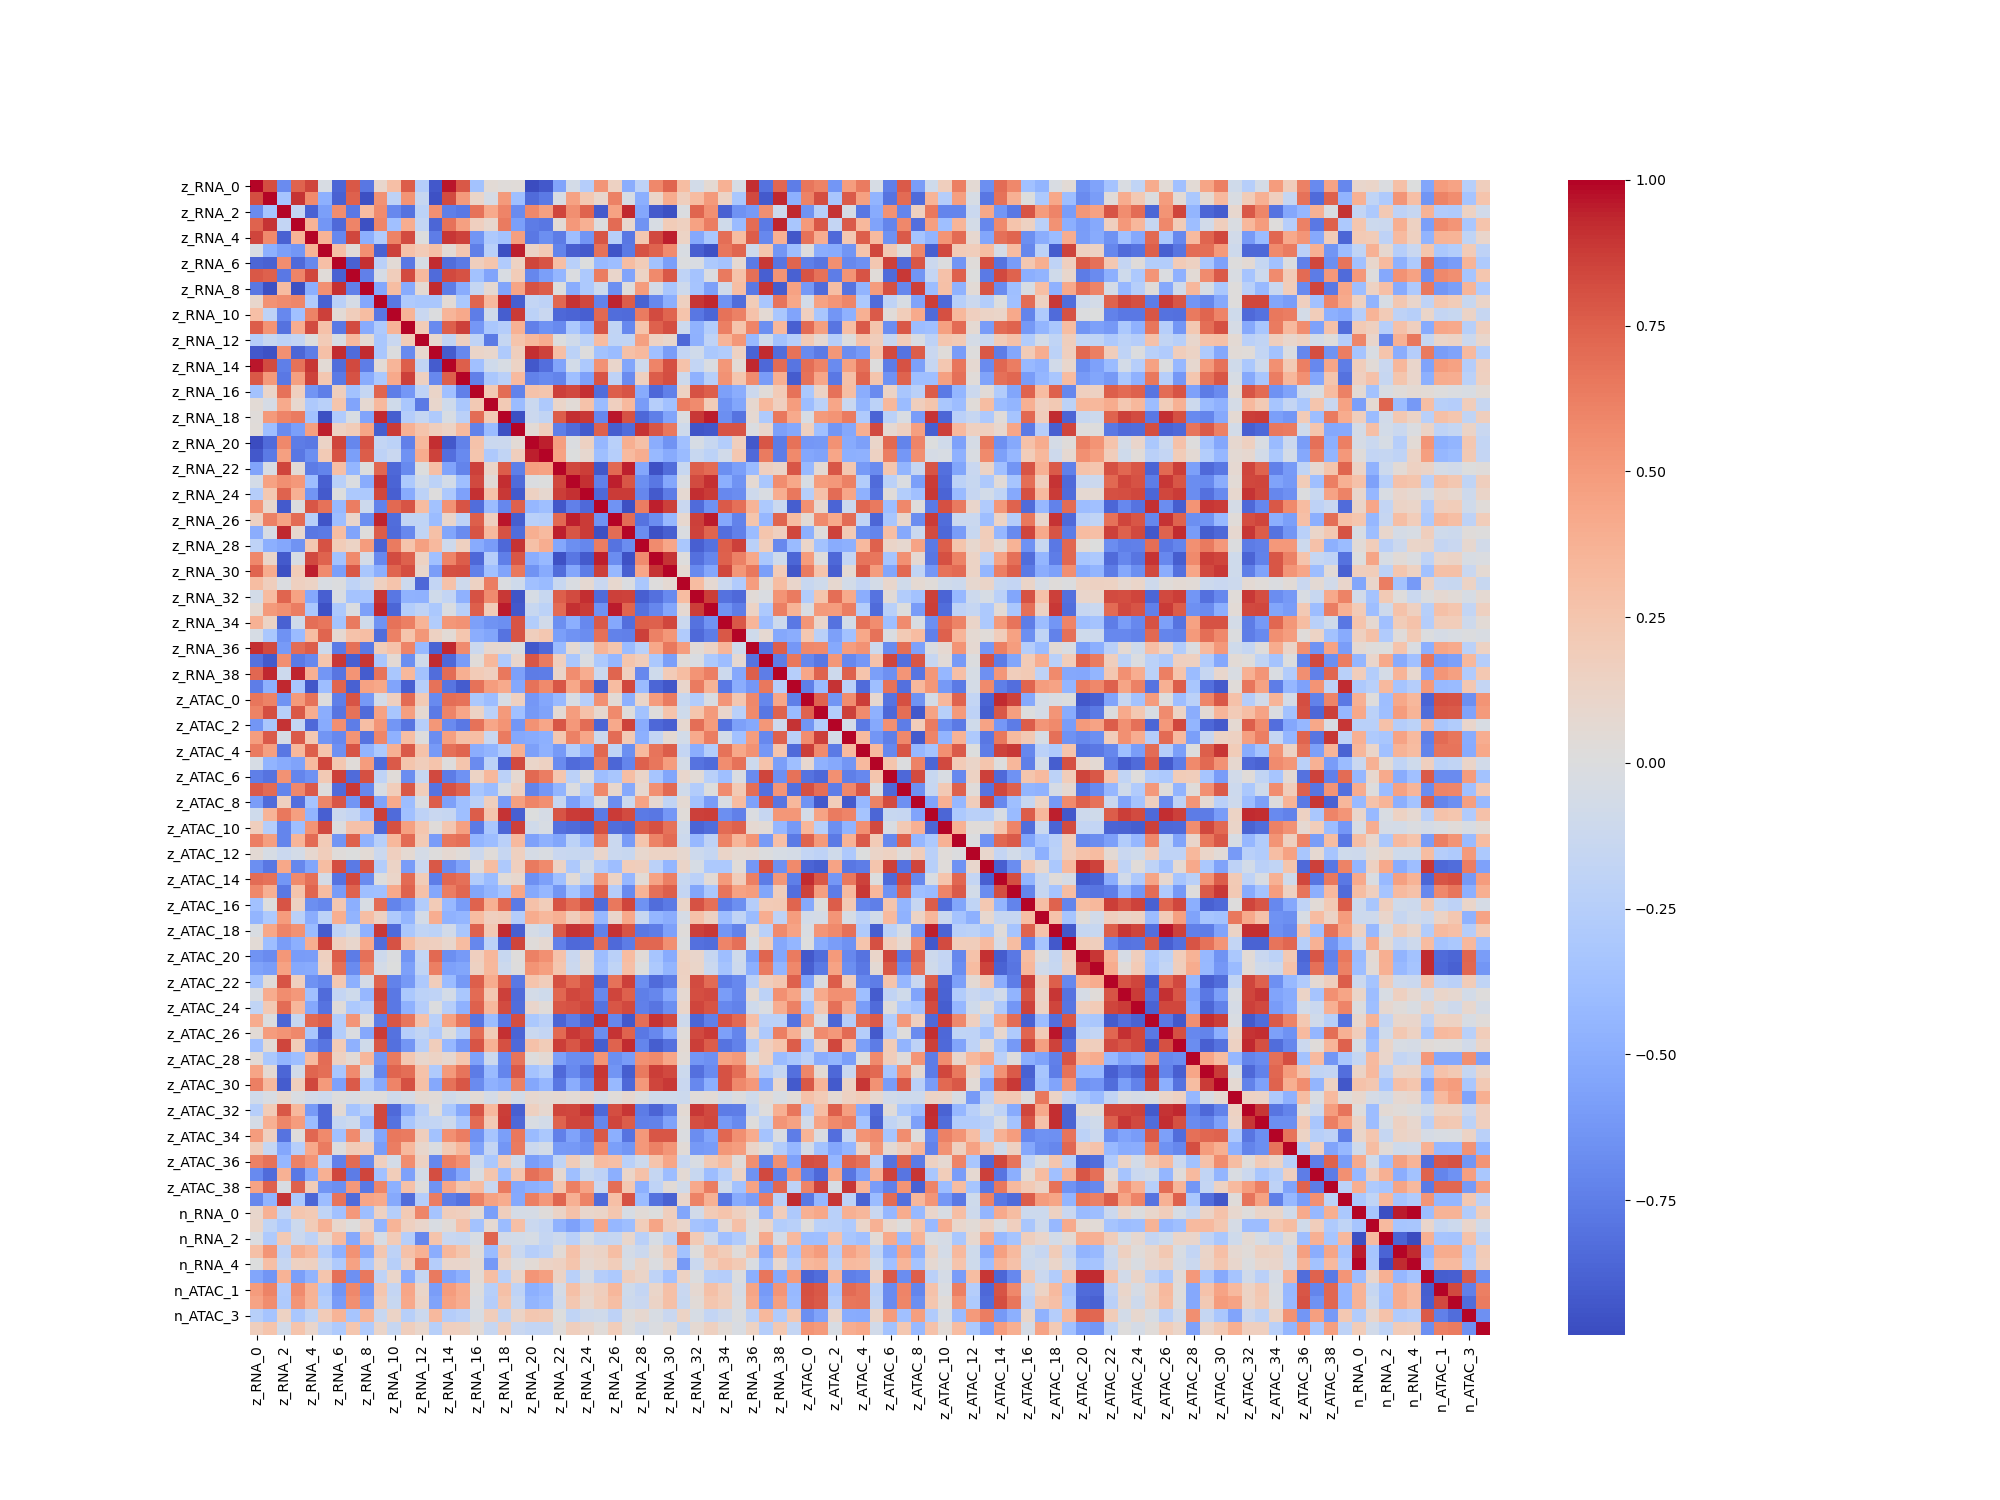

In [8]:
Image(filename='/home/paysan_d/PycharmProjects/domain_translation/data/a549_dex/final_experiments/pils_correct/80_0/fold_4/epoch_950/latent_space_correlation_structure_train.png', width = 800, height = 600)

To further validate the assumptions we will increase the dimensions of the latent space substantially. If our assumptions holds true, we should see a decrease of the reconstruction error in that scenario as soon as the size of the latent space exceeds the dimensionality of the true shared latent space of the two data domains.

---

#### 2c. ii) Latent space distance

To get a first impression on how close the paired samples are embedded in the shared latent space for the individual settings of supervision and shared latent space ratio, we analyze the empirical distributions of the $l_1$ distance of the paired samples in the validation folds for the cross-validation procedure. We normalize the $l_1$ distance that is average over the dimensions and samples by the mean distance between any unpaired samples.

The idea of the normalization is to compare the different configurations based on how close the paired samples come and not how close in general the samples come in the latent space measured in the $l_1$ distance.

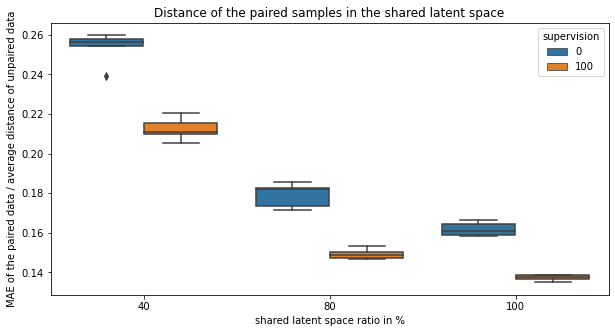

In [9]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
sn.boxplot(x='shared_ratio', y='latent_distance', hue='supervision', data=latent_distance_results, ax=ax)
ax.set_title('Distance of the paired samples in the shared latent space')
ax.set_xlabel('shared latent space ratio in %')
ax.set_ylabel('MAE of the paired data / average distance of unpaired data')
plt.show()

##### Summary

As expected we see a positive effect of supervision on how close the paired data comes in the latent space.

---

#### 2c. iii) kNN accuracy

Finally, we will evaluate the different settings with respect to the knn-accuracy that is defined as

$$
\textrm{kNN accuracy}(A,B) = \frac{\sum\limits_{(x,y) \in A\times B}1[z_x \in \mathcal{K}^z_y]}{n},
$$
where $n$ is the size of the data sets $A$ and $B$ of the two domains and $\mathcal{K}^z_y$ describes the set of k-nearest neighbors of the latent representation of the sample $y$ and $z_x$ is the latent representation (in the shared latent space) of the sample $x$.

Since this metric is not necessarily symmetric we take the unweighted average for our analysis.

In [34]:
knn_results['supervision'] = knn_results['supervision'].astype('category')

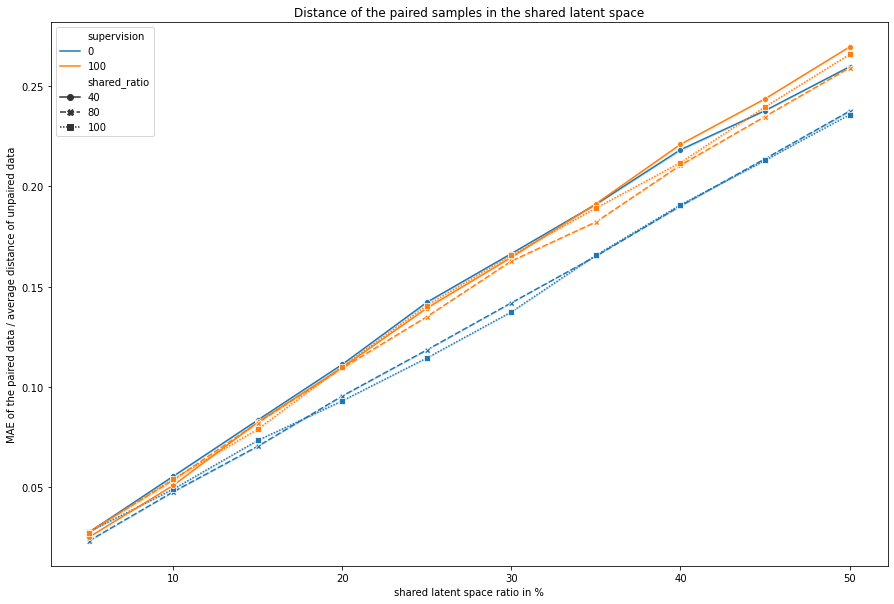

In [37]:
plt.figure(figsize=(15, 10))
ax = plt.axes()
sn.lineplot(x="k", y="knn_accuracy", hue="supervision", style='shared_ratio', data=knn_results, ci=0, 
            markers=True,ax=ax)
ax.set_title('Distance of the paired samples in the shared latent space')
ax.set_xlabel('shared latent space ratio in %')
ax.set_ylabel('MAE of the paired data / average distance of unpaired data')
plt.show()

##### Summary

The kNN accuracy results a) show that an increased level of supervision as expected helps to embed the pairs of sample in the latent space such that they are closer together. Additionally, the results suggest that the kNN accuracy decreases slightly if the ratio of shared latent dimensions increases.

However, these differences are not statistically significant and could be simply due to the curse of dimensionality which is a well-known problem for kNN approaches. 